In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishMorphology
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
!pip install scikit-plot
import scikitplot.metrics as splt
import re

warnings.filterwarnings("ignore")

Load data

<AxesSubplot:xlabel='Etiket', ylabel='count'>

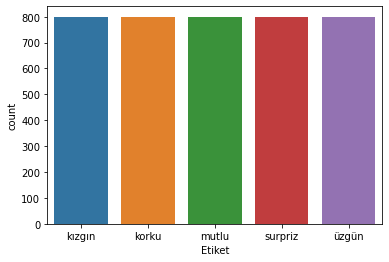

In [2]:
df=pd.read_csv("TurkishTweets.csv")
sns.countplot(x=df.Etiket)


Data preprocessing

In [3]:
sent_dict={'kızgın':0,'korku':1,'mutlu':2,'surpriz':3,'üzgün':4}
df["Etiket"]=df["Etiket"].map(sent_dict)
df.head()

,Tweet,Etiket
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,0
1,site ne zaman çalıştıda ürün stokları bitti di...,0
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,0
3,Black friday ne amk bu yıl çıkardınız bu bokud...,0
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,0


In [4]:
def clean_text(text):
    unwanted_pattern=r'[!.\n,:“”,?@#"]'
    regax=re.compile(unwanted_pattern)
    cleaned_text=regax.sub(" ",text)
    return cleaned_text
df["new_text"]=df["Tweet"].astype(str).apply(clean_text)
df["new_text"]=df["new_text"].str.replace("[\d]", "")
df["new_text"]=df["new_text"].str.lower()
df

,Tweet,Etiket,new_text
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,0,allah'ım çıldıracağım yemin ederim çıldıracağ...
1,site ne zaman çalıştıda ürün stokları bitti di...,0,site ne zaman çalıştıda ürün stokları bitti di...
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,0,sebebi neydi ki diye bağıracağım şimdi az kaldı
3,Black friday ne amk bu yıl çıkardınız bu bokud...,0,black friday ne amk bu yıl çıkardınız bu bokud...
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,0,kısa kısa cevaplar vericeksen niye yazıyorsun ...
...,...,...,...
3995,Aynı şeyleri yapmaktan sıkıldım,4,aynı şeyleri yapmaktan sıkıldım
3996,"Olacağı varsa oluyor ya hani, biteceği varsa d...",4,olacağı varsa oluyor ya hani biteceği varsa d...
3997,Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM,4,çok şey istiyorum ama sonu hep fiyasko mutsuzum
3998,Garip bir şekilde canım çok yanıyor moralim bozuk,4,garip bir şekilde canım çok yanıyor moralim bozuk


In [5]:
df=df.dropna()
df.isna().sum()

Tweet       0
Etiket      0
new_text    0
dtype: int64

In [6]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
ineffective=stopwords.words("Turkish")
ineffective[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['acaba', 'ama', 'aslında', 'az', 'bazı']

In [7]:
df["new_text"]=df["new_text"].apply(lambda x: " ".join(x for x in x.split() if x not in ineffective))
df.head()

,Tweet,Etiket,new_text
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,0,allah'ım çıldıracağım yemin ederim çıldıracağı...
1,site ne zaman çalıştıda ürün stokları bitti di...,0,site zaman çalıştıda ürün stokları bitti diyor...
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,0,sebebi neydi bağıracağım şimdi kaldı
3,Black friday ne amk bu yıl çıkardınız bu bokud...,0,black friday amk yıl çıkardınız bokuda mal mıs...
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,0,kısa kısa cevaplar vericeksen yazıyorsun geriz...


In [8]:
freq_data = df["Tweet"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis =0).reset_index()
freq_data.columns = ["kelimeler","frekanslar"]

In [9]:
freq_data=freq_data.sort_values(by='frekanslar', ascending=False)

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


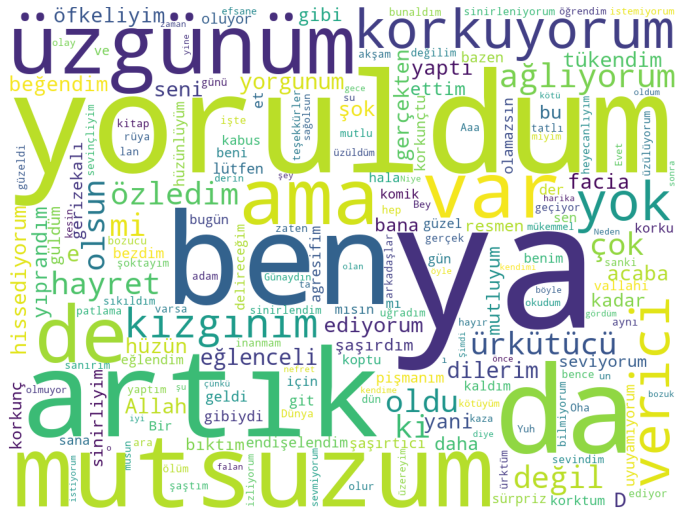

In [10]:
!pip install Wordcloud
from wordcloud import WordCloud
plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(list(freq_data["kelimeler"])))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [23]:
freq_data

,kelimeler,frekanslar
54,,813.0
74,bir,716.0
236,çok,702.0
35,bu,357.0
116,ve,315.0
...,...,...
5928,çektiğimi,1.0
5929,instada,1.0
5931,paylaşıyorsunuz,1.0
5932,sonda,1.0


Vectorizing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['new_text'], df['Etiket'], test_size=0.25, random_state=42)


tf_vector = TfidfVectorizer(max_features=5000)
ct_vector = CountVectorizer(max_features=5000)
X_train_vec = tf_vector.fit_transform(X_train).toarray() 
X_test_vec = tf_vector.transform(X_test).toarray() 
X_train_ct = ct_vector.fit_transform(X_train).toarray()  
X_test_ct = ct_vector.transform(X_test).toarray()

In [12]:

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score
from sklearn.metrics import f1_score
!pip install scikit-plot
from sklearn.metrics import confusion_matrix, classification_report
import scikitplot.metrics as splt
from sklearn.metrics import confusion_matrix, classification_report

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


Gaussian Naive Bayes Classification

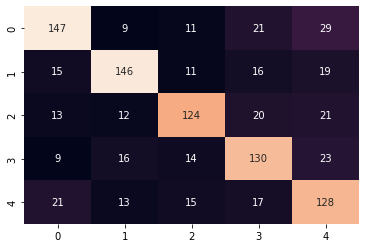

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       217
           1       0.74      0.71      0.72       207
           2       0.71      0.65      0.68       190
           3       0.64      0.68      0.66       192
           4       0.58      0.66      0.62       194

    accuracy                           0.68      1000
   macro avg       0.68      0.67      0.68      1000
weighted avg       0.68      0.68      0.68      1000



In [13]:
gnb_tf=GaussianNB()
gnb_tf.fit(X_train_vec, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cbar=False, fmt=".4g")
    plt.show()
    print(classification_report(y_test, y_pred))
    
result = pd.DataFrame(columns=['TF_Vectorizer_accuracy', 'Count_Vectorizer_accuracy', 'Model'])
    
evaluate_model(gnb_tf, X_test_vec, y_test)

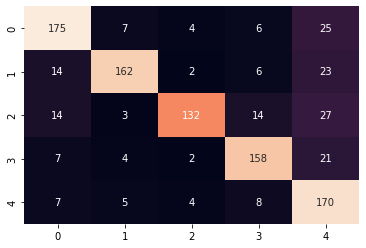

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       217
           1       0.90      0.78      0.84       207
           2       0.92      0.69      0.79       190
           3       0.82      0.82      0.82       192
           4       0.64      0.88      0.74       194

    accuracy                           0.80      1000
   macro avg       0.82      0.80      0.80      1000
weighted avg       0.82      0.80      0.80      1000



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.675,0.797,Gaussian Naive Bayes


In [14]:
gnb_ct = GaussianNB()
gnb_ct.fit(X_train_ct, y_train)
result = result.append({
                'Model': 'Gaussian Naive Bayes',
                'Count_Vectorizer_accuracy':gnb_ct .score(X_test_ct, y_test),
                'TF_Vectorizer_accuracy': gnb_tf.score(X_test_vec, y_test)},
                ignore_index=True)
evaluate_model(gnb_ct, X_test_ct, y_test)
result

# MultinomialNB

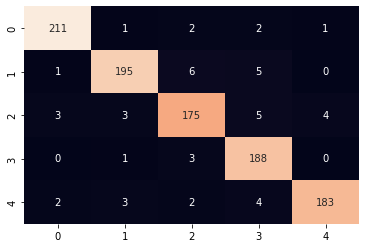

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       217
           1       0.96      0.94      0.95       207
           2       0.93      0.92      0.93       190
           3       0.92      0.98      0.95       192
           4       0.97      0.94      0.96       194

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [15]:
mnb_tf=MultinomialNB()
mnb_tf.fit(X_train_vec, y_train)
evaluate_model(mnb_tf, X_test_vec, y_test)

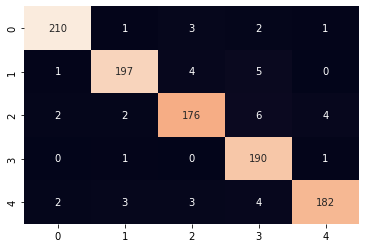

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       217
           1       0.97      0.95      0.96       207
           2       0.95      0.93      0.94       190
           3       0.92      0.99      0.95       192
           4       0.97      0.94      0.95       194

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.675,0.797,Gaussian Naive Bayes
1,0.952,0.955,Multinomial Naive Bayes


In [16]:
mnb_ct=MultinomialNB()
mnb_ct.fit(X_train_ct, y_train)
evaluate_model(mnb_ct, X_test_ct, y_test)
result = result.append({
                'Model': 'Multinomial Naive Bayes',
                'Count_Vectorizer_accuracy':mnb_ct .score(X_test_ct, y_test),
                'TF_Vectorizer_accuracy': mnb_tf.score(X_test_vec, y_test)},
                ignore_index=True)
result

# Logistic Regression

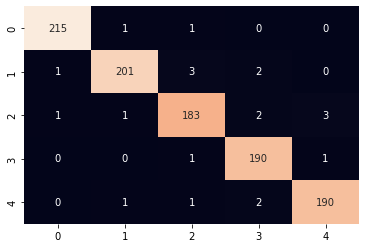

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       217
           1       0.99      0.97      0.98       207
           2       0.97      0.96      0.97       190
           3       0.97      0.99      0.98       192
           4       0.98      0.98      0.98       194

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [17]:
logr_tf=LogisticRegression(random_state = 0)
logr_tf.fit(X_train_vec, y_train)
evaluate_model(logr_tf, X_test_vec, y_test)

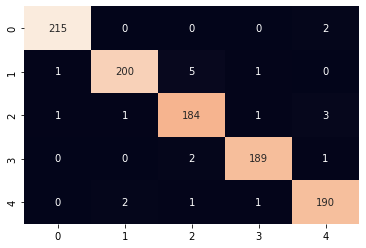

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       217
           1       0.99      0.97      0.98       207
           2       0.96      0.97      0.96       190
           3       0.98      0.98      0.98       192
           4       0.97      0.98      0.97       194

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.675,0.797,Gaussian Naive Bayes
1,0.952,0.955,Multinomial Naive Bayes
2,0.979,0.978,Logistic Regression


In [18]:
logr_ct=LogisticRegression(random_state = 0)
logr_ct.fit(X_train_ct, y_train)
evaluate_model(logr_ct, X_test_ct, y_test)
result = result.append({
                'Model': 'Logistic Regression',
                'Count_Vectorizer_accuracy':logr_ct .score(X_test_ct, y_test),
                'TF_Vectorizer_accuracy': logr_tf.score(X_test_vec, y_test)},
                ignore_index=True)
result

# K-NN

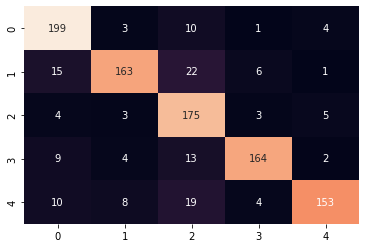

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       217
           1       0.90      0.79      0.84       207
           2       0.73      0.92      0.82       190
           3       0.92      0.85      0.89       192
           4       0.93      0.79      0.85       194

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000



In [19]:
knn_tf= KNeighborsClassifier(n_neighbors=12, metric='minkowski', p=2, weights='distance')
knn_tf.fit(X_train_vec, y_train)
evaluate_model(knn_tf, X_test_vec, y_test)

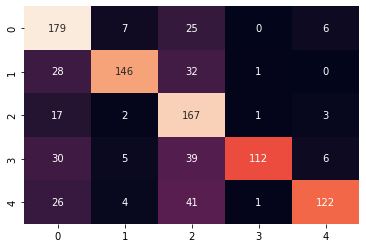

              precision    recall  f1-score   support

           0       0.64      0.82      0.72       217
           1       0.89      0.71      0.79       207
           2       0.55      0.88      0.68       190
           3       0.97      0.58      0.73       192
           4       0.89      0.63      0.74       194

    accuracy                           0.73      1000
   macro avg       0.79      0.72      0.73      1000
weighted avg       0.79      0.73      0.73      1000



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.675,0.797,Gaussian Naive Bayes
1,0.952,0.955,Multinomial Naive Bayes
2,0.979,0.978,Logistic Regression
3,0.854,0.726,K-NN


In [20]:
knn_ct= KNeighborsClassifier(n_neighbors=12, metric='minkowski', p=2, weights='distance')
knn_ct.fit(X_train_ct, y_train)
result = result.append({
                'Model': 'K-NN',
                'Count_Vectorizer_accuracy':knn_ct .score(X_test_ct, y_test),
                'TF_Vectorizer_accuracy': knn_tf.score(X_test_vec, y_test)},
                ignore_index=True)
evaluate_model(knn_ct, X_test_ct, y_test)
result

In [21]:
def test_models_on_tweet(tweet):
    # Veri önişleme
    tweet = clean_text(tweet)
    tweet = tweet.lower()
    tweet = " ".join(x for x in tweet.split() if x not in ineffective)
    
    # Vectorize
    tweet_tf = tf_vector.transform([tweet]).toarray() 
    tweet_ct = ct_vector.transform([tweet]).toarray() 
    
    # Makine öğrenmesi modellerinde test
    gnb_tf_pred = gnb_tf.predict(tweet_tf)[0]
    gnb_ct_pred = gnb_ct.predict(tweet_ct)[0]
    mnb_tf_pred = mnb_tf.predict(tweet_ct)[0]
    mnb_ct_pred = mnb_ct.predict(tweet_ct)[0]
    logr_tf_pred = logr_tf.predict(tweet_ct)[0]
    logr_ct_pred = logr_ct.predict(tweet_ct)[0]
    knn_tf_pred = knn_tf.predict(tweet_ct)[0]
    knn_ct_pred = knn_ct.predict(tweet_ct)[0]
    
    # Tahminleri sayılardan etiketlere dönüştürme
    sentiment_dict = {0: "kızgın", 1: "korku", 2: "mutlu", 3: "surpriz", 4: "üzgün"}
    gnb_tf_pred = sentiment_dict[gnb_tf_pred]
    gnb_ct_pred = sentiment_dict[gnb_ct_pred]
    mnb_tf_pred = sentiment_dict[mnb_tf_pred]
    mnb_ct_pred = sentiment_dict[mnb_ct_pred]
    logr_tf_pred = sentiment_dict[logr_tf_pred]
    logr_ct_pred = sentiment_dict[logr_ct_pred]
    knn_tf_pred = sentiment_dict[knn_tf_pred]
    knn_ct_pred =  sentiment_dict[knn_ct_pred]
    

    
    # Tahminleri ve model isimlerini döndürme
    return {
        "Gaussian Naive Bayes (TF Vectorizer)": gnb_tf_pred,
        "Gaussian Naive Bayes (Count Vectorizer)": gnb_ct_pred, 
        "Multinomial Naive Bayes (TF Vectorizer)": mnb_tf_pred,
        "Multinomial Naive Bayes (Count Vectorizer)": mnb_ct_pred,
        "Logistic Regression (TF Vectorizer)": logr_tf_pred,
        "Logistic Regression  (Count Vectorizer)": logr_ct_pred,
        "K-NN  (TF Vectorizer)": knn_tf_pred,
        "K-NN  (Count Vectorizer)": knn_ct_pred,
    }

In [22]:
tweet = "Offf acaba benim müstakbel kime oy attı"
predictions = test_models_on_tweet(tweet)
print(predictions)

{'Gaussian Naive Bayes (TF Vectorizer)': 'surpriz', 'Gaussian Naive Bayes (Count Vectorizer)': 'surpriz', 'Multinomial Naive Bayes (TF Vectorizer)': 'surpriz', 'Multinomial Naive Bayes (Count Vectorizer)': 'surpriz', 'Logistic Regression (TF Vectorizer)': 'surpriz', 'Logistic Regression  (Count Vectorizer)': 'mutlu', 'K-NN  (TF Vectorizer)': 'surpriz', 'K-NN  (Count Vectorizer)': 'kızgın'}
